In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from progressbar import progressbar
import scipy.stats
import statsmodels.stats.power as power
import statsmodels.formula.api as sfa
from functools import partial
import matplotlib.pyplot as plt
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})


# Exercises

This notebook builds on the notes in: [lecture-04-practical_sources_of_bias.ipynb](https://colab.research.google.com/drive/1oi1otu_ssyO-RJsH0YANn7HYKcBHeRqI).

This notebook is **all** of problem set 4. The "In-class foundations" will count as 50 percent.

## Part 1

We will further explore the bias in: "In the section "Adjusting randomization proportions during experiment".


### In-class foundations

1. Let's be clear about what kind of bias this is. Calculate the NATE decomposition. What kind of bias do we have in this example?

2. Check the **independence assumption** for this data set. Show that it does not hold.

3. Directly calculate the ATE from the data (which
 we can do because we have variables we wouldn't actually have!). Show that it matches what we set in the data-generating process.

4. Modify the "perfect stratification" analysis, which uses the day of the week. If we stratify by the **date**, do we get an unbiased estimate of the ATE? Why does this work?

5. We can also use regression to get an unbiased estimate. First, run a simple regression of `y ~ d` and confirm that you get the same naive estimate of the ATE. Then add `day_of_week` as a control variable. You need to use the `C()` dummy variable operator. Show that this gives you an unbiased estimate.



### To complete at home (30 points)

6. Modify the data-generating process by adding an "hour of day variable". You  can just add a column to the data set with a randomly generated number in 1,2,3,...,24. Does doing a perfect stratification analysis by the hour of the day give you an unbiased estimate of the ATE? **Explain your answer.**

7. Modify the data-generating process so that the **treatment effect** also varies by the day of the week. Let's imagine that since weekend visitors are less likely to convert they are generally less interested, so they also have a lower treatment effect. To make this very stark set the treatment effect to **0.005** on the weekend and **0.10** on weekdays. Implementing this in the DGP looks very similar to the conversion rate weekly cyclicality. You can do  adapting the function `daily_conversion_rates` and be sure to change the `ATE` variable from a constant to an array. Show these results: (i) Calculate the true ATE in the data, (ii) estimate the ATE using a regression like problem 5 with `day_of_week` control variables, and (iii) estimate the ATE using a perfect stratification on `day_of_week`. Which of the two estimators gives an unbiased estimate? 

8. Bonus (+5 points): Explain your answer in problem 7.

## Part 2

This part builds on the "Exposure to treatment" section and the more advanced scenarios.

### In-class foundations

9. Return the identification analysis ([link](https://colab.research.google.com/drive/1oi1otu_ssyO-RJsH0YANn7HYKcBHeRqI?authuser=2#scrollTo=yX0rTvQkKB9K&line=3&uniqifier=1)). Does including `viewed_page` as control variable in your regression give an un-biased estimate? Explain.

10. Generate a variable called `saw_treatment_page` that is 1 if the user actually saw the treatment page and 0 otherwise (either they didn't see the experiment page at all or saw the control version). Calculate the difference in conversion between users that saw the treatment page vs. the remainder. Does this give you an unbiased estimate? Why?

11. Go to the section "Probability of viewing page depends on charitability". If we slice the data by $D=0$ or D=1$ and calculate conversion rates, will that give us an unbiased estimate of the ATE?

12. In question 10 we saw that comparing users that actually saw the treatment page vs. the remainder gave us an unbiased estimate. Apply that approach here. Does it give you an unbiased estimate? Explain.

13. Try using regression to estimate the ATE. Add `charitability` as a control variable. Does this give you an unbiased estimate? What do you think of regression as an approach for removing bias from experiment results?

### To complete at home (20 points)

14. In the scenario "Probability of viewing page depends on charitability" how *should* we get an unbiased estimate of the ATE? Does your suggested method also work in the basic "Exposure to treatment" scenario?

15. In the last scenario "Charitability influences viewing probability *and* treatment effect" calculate the ATE **assuming** that everyone visited the page where the experiment is operative. The variables to help you do this should already be thre.

16. Now apply the method you suggested in problem 14. Does it give you an unbiased estimate of the ATE? Explain.

17. Bonus (+10 points): What lessons did you learn from this exercise? When do the various work? What advice would you give to someone working on an experiment like these scenarios?



#Part 1
##1

In [ ]:
def generate_one_experiment():
  # Average number of users of the site per day
  avg_N_per_day = 100000

  # One month of data (14 days)
  length_of_experiment = 14
  dates = np.arange(0, length_of_experiment)

  # This function causes our treatment percentage to go from 5% to 50%.
  def treatment_percent(date):
    if date <= 4:
      return 0.05
    else:
      return 0.50


  # Conversion on the weekend is 20 pp lower.
  # This function implements that weekly cyclicality.
  def daily_conversion_rates(day_of_week):
    if day_of_week in [5, 6]:
      return 0.10
    else:
      return 0.30

  # Determine the number of units on each day (use a Poisson distribution for convenience).
  N_each_day = np.random.poisson(avg_N_per_day, size=length_of_experiment)

  # Generate a row for each unit determined in the previous step.
  # We expect to have about 50,000 * 14 = 700,000 rows in the data.
  dates_of_units = np.concatenate([dates[ii] * np.ones(shape=N) for ii, N in np.ndenumerate(N_each_day)])


  # Make a dataframe with tracking the date on which each unit visited the site
  # and the day of the week.
  df = pd.DataFrame({
      'date': dates_of_units.astype('int'),
      'day_of_week': np.mod(dates_of_units, 7)
  })
  # Number the units from 0 through N.
  # We assumpe that each unit is a distinct individual.
  df['unit'] = df.index.values


  # The true ATE is 0.03, that is, the new site increases the probability 
  # of donation by 0.03.
  ATE = 0.03
  p_y0 = df['day_of_week'].apply(daily_conversion_rates)
  df['y0'] = np.random.binomial(n=1, p=p_y0)
  df['y1'] = np.random.binomial(n=1, p=p_y0 + ATE)


  # Apply the function that determines the percentage treated on each day.
  df['treatment_percent_by_day'] = df['date'].apply(treatment_percent)
  df['d'] = np.random.binomial(n=1, p=df['treatment_percent_by_day'])
  df['y'] = df.eval("d * y1 + (1 - d) * y0")
  return df

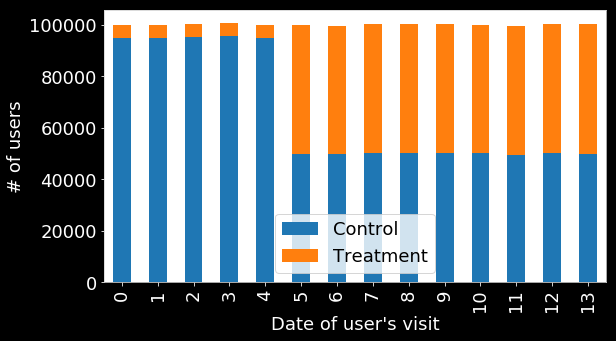

In [ ]:
np.random.seed(94115)
df = generate_one_experiment()
ax = df.groupby(['date', 'd'])['unit'].count().unstack(-1) \
  .rename(columns={0: 'Control', 1: 'Treatment'}) \
  .plot(kind='bar', stacked=True, figsize=(9, 5))
ax.set_ylabel("# of users", fontsize=18)
ax.set_xlabel("Date of user's visit", fontsize=18)
ax.tick_params(labelsize=18)
ax.legend(fontsize=18)
df = generate_one_experiment()

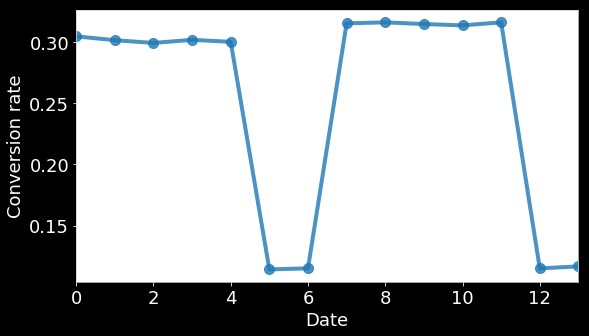

In [ ]:
ax = df.groupby(['date'])['y'].mean() \
  .plot(kind='line', marker='o', linewidth=4, markersize=10, alpha=0.8, figsize=(9, 5))
ax.set_ylabel("Conversion rate", fontsize=18)
ax.set_xlabel("Date", fontsize=18)
ax.tick_params(labelsize=18)

In [ ]:
# This function just estimates the NATE by taking the difference in rates.
def estimate_nate(df):
  means = df.groupby('d')['y'].mean()
  return means[1] - means[0]

# This function estimates the NATE on Friday, Monday, and the end of the experiment.
def check_experiment_results(df):
  return {
      'estimate_01_on_end_of_friday': estimate_nate(df.query("date <= 4")),
      'estimate_02_on_monday_morning': estimate_nate(df.query("date <= 6")),
      'estimate_03_end_of_experiment': estimate_nate(df),
  }

In [ ]:
df.groupby('d')['y'].mean()

d
0    0.257084
1    0.245455
Name: y, dtype: float64

In [ ]:
df

,date,day_of_week,unit,y0,y1,treatment_percent_by_day,d,y
0,0,0.0,0,1,0,0.05,0,1
1,0,0.0,1,0,0,0.05,0,0
2,0,0.0,2,0,1,0.05,0,0
3,0,0.0,3,0,0,0.05,0,0
4,0,0.0,4,1,0,0.05,0,1
5,0,0.0,5,0,0,0.05,0,0
6,0,0.0,6,1,0,0.05,1,0
7,0,0.0,7,0,1,0.05,0,0
8,0,0.0,8,0,1,0.05,0,0
9,0,0.0,9,1,0,0.05,0,1


In [ ]:
estimate_nate(df)

-0.011629541708549823

In [ ]:
#for i in np.array(0, )
#if df['y'] == 1:
 # print(df['y'])

In [ ]:
dff = []
for i in np.arange(0, 1400256):
  if df['d'][i] == 1:
    dff.append(df['y1'][i])
  

In [ ]:
dfff = []
for i in np.arange(0, 1400256):
  if df['d'][i] == 0:
    dfff.append(df['y0'][i])

In [ ]:
def Average(dff): 
    return sum(dff) / len(dff)

In [ ]:
Average(dff)

0.24545510049833363

In [ ]:
def Average1(dfff): 
    return sum(dfff) / len(dfff)

In [ ]:
Average1(dfff)

0.2570841254418966

In [ ]:
nate = Average(dff) - Average1(dfff)
nate

-0.011629024943562993

In [ ]:
dff1 = []
for i in np.arange(0, 1400256):
  if df['d'][i] == 0:
    dff1.append(df['y1'][i])

In [ ]:
#dff1 is Y1|D = 0
#dff is Y1|D=1
def Average11(dff1): 
    return sum(dff1) / len(dff1)

In [ ]:
Average(dff1)

0.2866970072616406

In [ ]:
Average(dff)

0.24545510049833363

In [ ]:
df['y1'].mean()

0.27270708162858676

In [ ]:
dfff1 = []
for i in np.arange(0, 1400256):
  if df['d'][i] == 1:
    dfff1.append(df['y0'][i])

In [ ]:
Average(dfff1)

0.21516980607727013

In [ ]:
Average(dfff)

0.2570841254418966

In [ ]:
df['y0'].mean()

0.24286613100309443

##2

In [ ]:
if df['y0'].mean() == Average(dfff) or df['y0'].mean() == Average(dfff1) or df['y1'].mean() == Average(dff) or df['y1'].mean() == Average(dff1):
  print('The independence assumption is held')
else:
  print('The independence assumption is not held')

The independence assumption is not held


##3

In [ ]:
ate_calc = df['y1'].mean() - df['y0'].mean()
ate_calc

0.02984095062549233

In [ ]:
#ATE = 0.03

##4

In [ ]:
from IPython.display import display
# Calculate an estimate of the ATE for each day of the week.
STRATA_VARIABLE = 'day_of_week'
conversion_rates_by_strata = df.groupby([STRATA_VARIABLE, 'd'])['y'].mean().unstack(-1)#unstack - photo with days, D, and Y
conversion_rates_by_strata.columns = ['control', 'treatment']
conversion_rates_by_strata['difference'] = conversion_rates_by_strata.eval("treatment - control")

# Calculate the number of units in each stratum
counts_by_strata = df.groupby([STRATA_VARIABLE])['y'].count()

conversion_rates_by_strata['counts'] = counts_by_strata

display(conversion_rates_by_strata)

# Calculate the *weighted-average* of the estimates.
# Note that in this very simple case we would get an unbiased estimate even
# if we did not weight the average. However, the weighted average has two advantages:
# (1) it gives a more precise estimate and a test with mroe power, and (2)
# if the treatment effects vary by strata it is still unbiased for the ATE.
print("\nEstimate of ATE (perfect stratification) = ", 
      conversion_rates_by_strata.eval("difference * counts").sum() / conversion_rates_by_strata['counts'].sum()
     )

,control,treatment,difference,counts
day_of_week,,,,
0.0,0.301907,0.330658,0.028751,199848
1.0,0.301008,0.328873,0.027866,200039
2.0,0.297830,0.330745,0.032915,200799
3.0,0.300248,0.326776,0.026528,200159
4.0,0.299823,0.329533,0.029710,199718
5.0,0.098929,0.130446,0.031516,200003
6.0,0.101693,0.130370,0.028678,199691



Estimate of ATE (perfect stratification) =  0.02942523978540548


In [ ]:
STRATA_VARIABLE = 'date'
conversion_rates_by_strata = df.groupby([STRATA_VARIABLE, 'd'])['y'].mean().unstack(-1)#unstack - photo with days, D, and Y
conversion_rates_by_strata.columns = ['control', 'treatment']
conversion_rates_by_strata['difference'] = conversion_rates_by_strata.eval("treatment - control")

# Calculate the number of units in each stratum
counts_by_strata = df.groupby([STRATA_VARIABLE])['y'].count()

conversion_rates_by_strata['counts'] = counts_by_strata

display(conversion_rates_by_strata)

# Calculate the *weighted-average* of the estimates.
# Note that in this very simple case we would get an unbiased estimate even
# if we did not weight the average. However, the weighted average has two advantages:
# (1) it gives a more precise estimate and a test with mroe power, and (2)
# if the treatment effects vary by strata it is still unbiased for the ATE.
print("\nEstimate of ATE (perfect stratification) = ", 
      conversion_rates_by_strata.eval("difference * counts").sum() / conversion_rates_by_strata['counts'].sum()
     )

,control,treatment,difference,counts
date,,,,
0,0.302948,0.333532,0.030584,99941
1,0.300172,0.324474,0.024302,99910
2,0.297615,0.328413,0.030798,100367
3,0.300228,0.329109,0.028880,99942
4,0.298767,0.324302,0.025535,100020
5,0.098682,0.129854,0.031172,99884
6,0.100655,0.129721,0.029066,99660
7,0.299930,0.330368,0.030438,99907
8,0.302592,0.329304,0.026712,100129



Estimate of ATE (perfect stratification) =  0.02892024466060566


In [ ]:
df.groupby(['date', 'd'])[['y1', 'y0']].mean()

y1        y0
date d                    
0    0  0.328774  0.302948
     1  0.333532  0.304348
1    0  0.328176  0.300172
     1  0.324474  0.295441
2    0  0.328813  0.297615
     1  0.328413  0.289585
3    0  0.331206  0.300228
     1  0.329109  0.300543
4    0  0.329627  0.298767
     1  0.324302  0.294986
5    0  0.132580  0.098682
     1  0.129854  0.099944
6    0  0.132138  0.100655
     1  0.129721  0.098690
7    0  0.332907  0.299930
     1  0.330368  0.297643
8    0  0.329027  0.302592
     1  0.329304  0.304109
9    0  0.328861  0.298238
     1  0.330976  0.298845
10   0  0.328178  0.300286
     1  0.326546  0.299256
11   0  0.332105  0.301833
     1  0.330052  0.300765
12   0  0.126702  0.099176
     1  0.131036  0.099208
13   0  0.130419  0.102720
     1  0.131021  0.098186

##5

In [ ]:
#NATE = E[Y1|D=1] - E[Y0|D=0]
natetable = df.groupby(['d'])[['y1', 'y0', 'y']].mean()
natetable

,y1,y0,y
d,,,
0,0.286697,0.257084,0.257084
1,0.245455,0.215169,0.245455


In [ ]:
nate_est = natetable['y1'][1] - natetable['y0'][0]
nate_est # this one

-0.011629541708549823

In [ ]:
nate1 = estimate_nate(df)
nate1 #check

-0.011629541708549823

In [ ]:
print(sfa.ols("y ~ d + C(day_of_week)", df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     8569.
Date:                Tue, 24 Sep 2019   Prob (F-statistic):               0.00
Time:                        00:22:29   Log-Likelihood:            -7.9131e+05
No. Observations:             1400257   AIC:                         1.583e+06
Df Residuals:                 1400249   BIC:                         1.583e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.30

In [ ]:
#our estimation of d is closed to the value of true ATE so this estimate is unbiased.

##6

In [ ]:
len(df)

1400257

In [ ]:
def generate_one_experiment_new():
  # Average number of users of the site per day
  avg_N_per_day = 100000

  # One month of data (14 days)
  length_of_experiment = 14
  dates = np.arange(0, length_of_experiment)

  # This function causes our treatment percentage to go from 5% to 50%.
  def treatment_percent(date):
    if date <= 4:
      return 0.05
    else:
      return 0.50


  # Conversion on the weekend is 20 pp lower.
  # This function implements that weekly cyclicality.
  def daily_conversion_rates(day_of_week):
    if day_of_week in [5, 6]:
      return 0.10
    else:
      return 0.30

  # Determine the number of units on each day (use a Poisson distribution for convenience).
  N_each_day = np.random.poisson(avg_N_per_day, size=length_of_experiment)

  # Generate a row for each unit determined in the previous step.
  # We expect to have about 50,000 * 14 = 700,000 rows in the data.
  dates_of_units = np.concatenate([dates[ii] * np.ones(shape=N) for ii, N in np.ndenumerate(N_each_day)])


  # Make a dataframe with tracking the date on which each unit visited the site
  # and the day of the week.
  df = pd.DataFrame({
      'date': dates_of_units.astype('int'),
      'day_of_week': np.mod(dates_of_units, 7)
  })
  # Number the units from 0 through N.
  # We assumpe that each unit is a distinct individual.
  df['unit'] = df.index.values


  # The true ATE is 0.03, that is, the new site increases the probability 
  # of donation by 0.03.
  ATE = 0.03
  p_y0 = df['day_of_week'].apply(daily_conversion_rates)
  df['y0'] = np.random.binomial(n=1, p=p_y0)
  df['y1'] = np.random.binomial(n=1, p=p_y0 + ATE)
  df['hour_of_day'] = np.random.randint(0, 23, size = len(df))

  # Apply the function that determines the percentage treated on each day.
  df['treatment_percent_by_day'] = df['date'].apply(treatment_percent)
  df['d'] = np.random.binomial(n=1, p=df['treatment_percent_by_day'])
  df['y'] = df.eval("d * y1 + (1 - d) * y0")
  return df

In [ ]:
df = generate_one_experiment_new()
df

,date,day_of_week,unit,y0,y1,hour_of_day,treatment_percent_by_day,d,y
0,0,0.0,0,1,0,3,0.05,0,1
1,0,0.0,1,0,1,8,0.05,0,0
2,0,0.0,2,1,0,6,0.05,0,1
3,0,0.0,3,0,0,4,0.05,0,0
4,0,0.0,4,0,0,3,0.05,0,0
5,0,0.0,5,0,0,16,0.05,0,0
6,0,0.0,6,0,0,5,0.05,0,0
7,0,0.0,7,0,1,13,0.05,0,0
8,0,0.0,8,0,0,14,0.05,0,0
9,0,0.0,9,0,1,13,0.05,0,0


In [ ]:
print(sfa.ols("y ~ d + C(hour_of_day)", df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     9.371
Date:                Tue, 24 Sep 2019   Prob (F-statistic):           3.23e-33
Time:                        00:22:40   Log-Likelihood:            -8.1979e+05
No. Observations:             1399873   AIC:                         1.640e+06
Df Residuals:                 1399849   BIC:                         1.640e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2565 

In [ ]:
#d estimate and True ATE are different. So it means that estimate is not unbiased. 
#The reason for occuring it is the fact that dates are close connected to days of week, 
#as compared to hours as they are orthogonal to week days.

##7

Modify the data-generating process so that the **treatment effect** also varies by the day of the week. Let's imagine that since weekend visitors are less likely to convert they are generally less interested, so they also have a lower treatment effect. To make this very stark set the treatment effect to **0.005** on the weekend and **0.10** on weekdays. Implementing this in the DGP looks very similar to the conversion rate weekly cyclicality. You can do  adapting the function `daily_conversion_rates` and be sure to change the `ATE` variable from a constant to an array. Show these results: (i) Calculate the true ATE in the data, (ii) estimate the ATE using a regression like problem 5 with `day_of_week` control variables, and (iii) estimate the ATE using a perfect stratification on `day_of_week`. Which of the two estimators gives an unbiased estimate? 

In [ ]:
def generate_one_experiment_new():
  # Average number of users of the site per day
  avg_N_per_day = 100000

  # One month of data (14 days)
  length_of_experiment = 14
  dates = np.arange(0, length_of_experiment)

  # This function causes our treatment percentage to go from 5% to 50%.
  def treatment_percent(date):
    if date <= 4:
      return 0.05
    else:
      return 0.50


  # Conversion on the weekend is 20 pp lower.
  # This function implements that weekly cyclicality.
  def daily_conversion_rates(day_of_week):
    if day_of_week in [5, 6]:
      return 0.10
    else:
      return 0.30
    
    
    
  def ate_day(day_of_week):
    if day_of_week in [5, 6]:
      return 0.005
    else:
      return 0.1  
  

  # Determine the number of units on each day (use a Poisson distribution for convenience).
  N_each_day = np.random.poisson(avg_N_per_day, size=length_of_experiment)

  # Generate a row for each unit determined in the previous step.
  # We expect to have about 50,000 * 14 = 700,000 rows in the data.
  dates_of_units = np.concatenate([dates[ii] * np.ones(shape=N) for ii, N in np.ndenumerate(N_each_day)])


  # Make a dataframe with tracking the date on which each unit visited the site
  # and the day of the week.
  df = pd.DataFrame({
      'date': dates_of_units.astype('int'),
      'day_of_week': np.mod(dates_of_units, 7)
  })
  # Number the units from 0 through N.
  # We assumpe that each unit is a distinct individual.
  df['unit'] = df.index.values


  # The true ATE is 0.03, that is, the new site increases the probability 
  # of donation by 0.03.
 
  ATE = df['day_of_week'].apply(ate_day)
  p_y0 = df['day_of_week'].apply(daily_conversion_rates)
  df['y0'] = np.random.binomial(n=1, p=p_y0)
  df['y1'] = np.random.binomial(n=1, p=p_y0 + ATE)
  df['hour_of_day'] = np.random.randint(0, 23, size = len(df))

  # Apply the function that determines the percentage treated on each day.
  df['treatment_percent_by_day'] = df['date'].apply(treatment_percent)
  df['d'] = np.random.binomial(n=1, p=df['treatment_percent_by_day'])
  df['y'] = df.eval("d * y1 + (1 - d) * y0")
  return df

###i)

In [ ]:
df = generate_one_experiment_new()
true_ate = df['y1'].mean() - df['y0'].mean()

In [ ]:
true_ate

0.0723177632308887

###ii)

In [ ]:
df = generate_one_experiment_new()

In [ ]:
def regression_ate1(df, formula="y ~ d + C(day_of_week)"):
  r = sfa.ols(formula, df).fit()
  return {
      'estimated_ate': r.params['d'],
      'estimated_ate_se': r.bse['d'],
      'p': r.pvalues['d'],
      
  }


# Generate a large data set because we are looking at identification.
df = generate_one_experiment_new()
# Our results show that the estimate is about 0.02.
# But we set the ATE to 0.20!
result = regression_ate1(df)
print(result, "\n")

{'estimated_ate': 0.06741512340252415, 'estimated_ate_se': 0.0007806241666893381, 'p': 0.0} 



In [ ]:
print(sfa.ols("y ~ d + C(day_of_week)", df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                 1.241e+04
Date:                Tue, 24 Sep 2019   Prob (F-statistic):               0.00
Time:                        00:22:56   Log-Likelihood:            -7.9541e+05
No. Observations:             1399357   AIC:                         1.591e+06
Df Residuals:                 1399349   BIC:                         1.591e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.30

###iii)

In [ ]:
from IPython.display import display
# Calculate an estimate of the ATE for each day of the week.
STRATA_VARIABLE = 'day_of_week'
conversion_rates_by_strata = df.groupby([STRATA_VARIABLE, 'd'])['y'].mean().unstack(-1)#unstack - photo with days, D, and Y
conversion_rates_by_strata.columns = ['control', 'treatment']
conversion_rates_by_strata['difference'] = conversion_rates_by_strata.eval("treatment - control")

# Calculate the number of units in each stratum
counts_by_strata = df.groupby([STRATA_VARIABLE])['y'].count()

conversion_rates_by_strata['counts'] = counts_by_strata

display(conversion_rates_by_strata)

# Calculate the *weighted-average* of the estimates.
# Note that in this very simple case we would get an unbiased estimate even
# if we did not weight the average. However, the weighted average has two advantages:
# (1) it gives a more precise estimate and a test with mroe power, and (2)
# if the treatment effects vary by strata it is still unbiased for the ATE.
print("\nEstimate of ATE (perfect stratification) = ", 
      conversion_rates_by_strata.eval("difference * counts").sum() / conversion_rates_by_strata['counts'].sum()
     )

,control,treatment,difference,counts
day_of_week,,,,
0.0,0.300177,0.397815,0.097639,199678
1.0,0.298636,0.398739,0.100102,199533
2.0,0.301129,0.399397,0.098268,199633
3.0,0.299907,0.402155,0.102248,199758
4.0,0.300628,0.398316,0.097687,200090
5.0,0.100434,0.103805,0.003372,200202
6.0,0.100037,0.105044,0.005007,200463



Estimate of ATE (perfect stratification) =  0.07198834840622156


ANSWER: both of estimators are unbiased.

##Bonus

**ANSWER :** estimators are unbiased because both of them have the same control variable and our data is generated on this control variable, i.e. our regression and stratification methods are run by day of the week. Similarly, our data is generated by day. It means we will not have unbiased estimate

#Part 2
##9. Return the identification analysis ([link](https://colab.research.google.com/drive/1oi1otu_ssyO-RJsH0YANn7HYKcBHeRqI?authuser=2#scrollTo=yX0rTvQkKB9K&line=3&uniqifier=1)). Does including `viewed_page` as control variable in your regression give an un-biased estimate? Explain.

In [ ]:
#yes, our experiment becomes unbiased as control variable viewed_page is randomly distributed so it means that we give treatment for people randomly

In [ ]:
def generate_one_experiment(p_viewed_page=0.1, N=1000):
  units = np.arange(0, N)
  
  # Did the user view the page that where we are running the experiment?
  viewed_page = np.random.binomial(n=1, p=p_viewed_page, size=N)
  
  ATE_asterisk = 0.20
  D = np.random.binomial(n=1, p=0.5, size=N)

  Y0 = np.random.binomial(n=1, p=0.2, size=N)
  Y1 = np.random.binomial(n=1, p=0.2 + ATE_asterisk * viewed_page * D, size=N)
  Y = D * Y1 + (1 - D) * Y0
  
  df = pd.DataFrame({
      'unit': units,
      'viewed_page': viewed_page,
      'd': D,
      'y0': Y0,
      'y1': Y1,
      'y': Y
  })
  return df

In [ ]:
def regression_ate(df, formula="y ~ d + viewed_page"):
  r = sfa.ols(formula, df).fit()
  return {
      'estimated_ate': r.params['d'],
      'estimated_ate_se': r.bse['d'],
      'p': r.pvalues['d'],
      
  }


# Generate a large data set because we are looking at identification.
df = generate_one_experiment(N=10 ** 6)

# Our results show that the estimate is about 0.02.
# But we set the ATE to 0.20!
result = regression_ate(df)
print("Results from a regression on all the data")
print(result, "\n")

# When we estimate the results with just users that saw the page
# then we get an unbiased estimate of ~0.20.
print("Results from a regression on just users that saw the page")
print(regression_ate(df.query("viewed_page == 1")), "\n")
#no direct effect on tretamnet when we choose control variable for instance for treatmnet group it will be effected when people view page
#but for control group who viewed page will be no effect from this control variable
#as control group will never see the page(treatment effect) so the control variable will be equal 0

Results from a regression on all the data
{'estimated_ate': 0.020553733854502963, 'estimated_ate_se': 0.0008125799603919747, 'p': 4.0775377170943305e-141} 

Results from a regression on just users that saw the page
{'estimated_ate': 0.19989625039255976, 'estimated_ate_se': 0.0028214102289966215, 'p': 0.0} 



In [ ]:
print(sfa.ols("y ~ d + C(viewed_page)", df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2977.
Date:                Tue, 24 Sep 2019   Prob (F-statistic):               0.00
Time:                        00:23:01   Log-Likelihood:            -5.1825e+05
No. Observations:             1000000   AIC:                         1.037e+06
Df Residuals:                  999997   BIC:                         1.037e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1901    

**ANSWER :** the esimate is unbiased when the control variable viewed_page is randomly distributed so it means that we give treatment for people randomly during this experiment. 

##10

In [ ]:
df

,unit,viewed_page,d,y0,y1,y
0,0,0,0,0,1,0
1,1,0,1,1,1,1
2,2,0,1,0,0,0
3,3,0,1,0,1,1
4,4,0,0,0,1,0
5,5,0,0,0,0,0
6,6,0,0,0,0,0
7,7,0,0,0,0,0
8,8,0,1,1,0,0
9,9,0,0,0,0,0


In [ ]:
saw_treatment_page = np.random.binomial(n=1, p=.5)

In [ ]:
def generate_one_experiment1(p_viewed_page=0.1, N=1000):
  units = np.arange(0, N)
  
  # Did the user view the page that where we are running the experiment?
  viewed_page = np.random.binomial(n=1, p=p_viewed_page, size=N)
  
  ATE_asterisk = 0.20
  D = np.random.binomial(n=1, p=0.5, size=N)
  saw_treatment_page = np.random.binomial(n=1, p=.5, size = N)
  Y0 = np.random.binomial(n=1, p=0.2, size=N)
  Y1 = np.random.binomial(n=1, p=0.2 + ATE_asterisk * viewed_page * D, size=N)
  Y = D * Y1 + (1 - D) * Y0
  
  dfd = pd.DataFrame({
       'unit': units,
       'viewed_page': viewed_page,
       'd': D,
       'y0': Y0,
       'y1': Y1,
       'y': Y,
       'saw_treatment_page' : saw_treatment_page
  })
  return dfd

In [ ]:
dfd = generate_one_experiment1()

In [ ]:
N = 1000
for i in np.arange(0, N):
  if dfd['viewed_page'][i] == 1 and dfd['d'][i] == 1:
    dfd['saw_treatment_page'][i] = 1
  else:
    dfd['saw_treatment_page'][i] = 0

In [ ]:
dfd

,unit,viewed_page,d,y0,y1,y,saw_treatment_page
0,0,0,1,0,1,1,0
1,1,0,0,0,0,0,0
2,2,0,1,0,0,0,0
3,3,0,0,0,0,0,0
4,4,0,1,0,0,0,0
5,5,0,0,0,0,0,0
6,6,0,1,0,0,0,0
7,7,0,1,0,0,0,0
8,8,0,1,0,0,0,0
9,9,0,1,0,0,0,0


In [ ]:
viewpage_k = 0
for i in range(len(dfd)):
  if dfd['saw_treatment_page'][i] == 1:
    viewpage_k +=1
  else:
    viewpage_k +=0

In [ ]:
viewpage_k

44

In [ ]:
conv_rate1 = viewpage_k/len(dfd)
conv_rate2 = 1 - conv_rate1
print('conversion "viewed page" = ', conv_rate1)
print('conversion remainder = ', conv_rate2)

conversion "viewed page" =  0.044
conversion remainder =  0.956


In [ ]:
print(dfd.query('saw_treatment_page==1')['y'].mean())
print(dfd.query('saw_treatment_page==0')['y'].mean())

0.4318181818181818
0.20606694560669456


In [ ]:
diff_cov = dfd.query('saw_treatment_page==1')['y'].mean() - dfd.query('saw_treatment_page==0')['y'].mean()
print('Difference in conversions = ', diff_cov)

Difference in conversions =  0.22575123621148727


In [ ]:
print(dfd.query("saw_treatment_page == 1").groupby('d')['y1'].mean() - dfd.query("saw_treatment_page == 1").groupby('d')['y0'].mean(), "\n")

d
1    0.227273
dtype: float64 



**ANSWER :** yes, this estimate is unbiased, as now our control varible works in an appropriate way. the saw_treatment_page could be equal 1 only if people are under treatment and they viewed page

##11

In [ ]:
# Heterogenous view probabilities

def generate_one_experiment_12(p_viewed_page=0.1, N=1000):
  units = np.arange(0, N)
  
  charitability = np.random.normal(loc=0, scale=1, size=N)
  
  # Did the user view the page that where we are running the experiment?
  viewed_page = np.random.binomial(n=1, p=scipy.special.expit(charitability))
  
  
  ATE_asterisk = 0.10
  D = np.random.binomial(n=1, p=0.5, size=N)
  saw_treatment_page = viewed_page * D

  # Restrict baseline donation level to [0, 0.5] so we can plug in the ATE
  # and still have a valid probability.
  p_donate_baseline = np.clip(scipy.special.expit(charitability - 1), 0, 0.5)
  Y0 = np.random.binomial(n=1, p=p_donate_baseline, size=N)
  Y1 = np.random.binomial(n=1, p=p_donate_baseline + ATE_asterisk * saw_treatment_page, size=N)
  Y = D * Y1 + (1 - D) * Y0
  
  df1 = pd.DataFrame({
      'unit': units,
      'viewed_page': viewed_page,
      'charitability': charitability,
      'd': D,
      'y0': Y0,
      'y1': Y1,
      'y': Y,
      'saw_treatment_page': saw_treatment_page
  })
  return df1

In [ ]:
#Conversion
df1 = generate_one_experiment_12()
df1.groupby('d')['y'].mean()

d
0    0.276803
1    0.363450
Name: y, dtype: float64

In [ ]:
df1

,unit,viewed_page,charitability,d,y0,y1,y,saw_treatment_page
0,0,1,0.614572,0,1,0,1,0
1,1,1,-0.287590,0,1,1,1,0
2,2,1,2.115669,0,0,1,0,0
3,3,0,-0.291791,1,0,1,1,0
4,4,1,0.394769,1,0,1,1,1
5,5,1,1.475152,0,1,1,1,0
6,6,1,-0.804076,1,1,0,0,1
7,7,0,-1.519398,0,0,0,0,0
8,8,0,-1.093695,0,0,0,0,0
9,9,1,2.226644,1,1,0,0,1


In [ ]:
print(df1.query("d == 1").groupby('d')['y1'].mean() - df1.query("d == 1").groupby('d')['y0'].mean(), "\n")
print(df1.query("d == 0").groupby('d')['y1'].mean() - df1.query("d == 0").groupby('d')['y0'].mean(), "\n")

d
1    0.078029
dtype: float64 

d
0    0.035088
dtype: float64 



**Answer :** The estimate is biased as we set ate as 0.1 and got after slicing data for treatment(d=1) and non-treatment (d=0) estimates 0.03 and 0.02 respectively.

##12

In [ ]:
print(df1.query("saw_treatment_page == 1")['y1'].mean() - df1.query("saw_treatment_page == 1")['y0'].mean(), "\n")

0.11764705882352944 



**ANSWER :** the estimate is not unbiased. The reason is the fact that

##13

In [ ]:
def regression_ate1(df1, formula="y ~ d + charitability"):
  r = sfa.ols(formula, df1).fit()
  return {
      'estimated_ate': r.params['d'],
      'estimated_ate_se': r.bse['d'],
      'p': r.pvalues['d'],
      
  }
df1 = generate_one_experiment_12()
result = regression_ate1(df1)
print(result, "\n")

{'estimated_ate': 0.08806031037099397, 'estimated_ate_se': 0.027648968022116284, 'p': 0.001492758981470917} 



**ANSWER :** no, our estimate is biased. Originally ate = 0.1 although we have 0.048. Regression is one of the methods to remove bias from experiments but, clearly, it playes a vital role which value you choose for control variable. It means that when we choose control variable, it has to be independent from other values.



##14

**ANSWER :** in the scenario "Probability of viewing page depends on charitability" we should get an unbiased estimate of the ATE if we calculate ate after grouping by "viewed page". I think it will work in the "exposure" to treatment scenario as our variable "viewed page" is random. Moreover, I suppose that we could do experiments via variables which will be independent to others. In other words, for instance, the value "charitability" is high, then the probability of viewing page by person, who has this high rate of charitability, will be also more than if charitability rate is low.

##15

In [ ]:
# Heterogenous view probabilities and treatment effects

def generate_one_experiment(N = 10000):
  units = np.arange(0, N)
  
  charitability = np.random.normal(loc=0, scale=1, size=N)
  
  # Did the user view the page that where we are running the experiment?
  viewed_page = np.random.binomial(n=1, p=scipy.special.expit(charitability))
  
  
  ITE = 0.2 * scipy.special.expit(charitability)
  D = np.random.binomial(n=1, p=0.5, size=N)
  saw_treatment_page = viewed_page * D

  # Restrict baseline donation level to [0, 0.5] so we can plug in the ATE
  # and still have a valid probability.
  p_donate_baseline = np.clip(scipy.special.expit(charitability - 1), 0, 0.5)
  Y0 = np.random.binomial(n=1, p=p_donate_baseline, size=N)
  
  # We will treat the ATE as being the effect of seeing the treatment page vs.
  # seeing the control page. So the ATE only kicks in if the user visited
  # the page at all.
  Y1 = np.random.binomial(n=1, p=p_donate_baseline + ITE * viewed_page, size=N)
  
  # For demonstrative purposes, we create another potential outcome where we
  # assume that everyone goes to the page AND sees the treatment version.
  Y1_assume_viewed = np.random.binomial(n=1, p=p_donate_baseline + ITE, size=N)
  
  Y = D * Y1 + (1 - D) * Y0
  
  dfw = pd.DataFrame({
      'unit': units,
      'viewed_page': viewed_page,
      'charitability': charitability,
      'd': D,
      'y0': Y0,
      'y1': Y1,
      'y1_assume_viewed': Y1_assume_viewed,
      'y': Y,
      'saw_treatment_page': saw_treatment_page,
      'ite': ITE
  })
  return dfw

In [ ]:
dfw = generate_one_experiment(N= 10 ** 6)
ate_with_assum = dfw['y1_assume_viewed'].mean() - dfw['y0'].mean()
ate_with_assum

0.10042999999999996

##16

In [ ]:
ate_t = dfw.query("viewed_page == 1")['y1'].mean() - dfw.query("viewed_page == 1")['y0'].mean()
ate_t

0.11873658607812432

In [ ]:
ate_test = dfw.groupby(['viewed_page'])['y1'].mean() - dfw.groupby(['viewed_page'])['y0'].mean()
ate_test

viewed_page
0   -0.000246
1    0.118737
dtype: float64